## Classifying newswires: A multiclass classification example

In this section, we’ll build a model to classify Reuters newswires into 46 mutually exclusive topics. Because we have many classes, this problem is an instance of multiclass classification, and because each data point should be classified into only one category, the problem is more specifically an instance of single-label multiclass classification.

If each data point could belong to multiple categories (in this case, topics), we’d be facing a multilabel multiclass classification problem.

You’ll work with the Reuters dataset, a set of short newswires and their topics, published by Reuters in 1986. It’s a simple, widely used toy dataset for text classification. There are 46 different topics; some topics are more represented than others, but each topic has at least 10 examples in the training set.

In [84]:
from keras.datasets import reuters
(train_data, train_labels), (test_data,test_labels) = reuters.load_data(num_words=10000)

As with the IMDB dataset, the argument num_words=10000 restricts the data to the 10,000 most frequently occurring words found in the data. You have 8,982 training examples and 2,246 test examples:

In [85]:
len(train_data)

8982

In [86]:
len(test_data)

2246

In [87]:
# decoding newswires back to text

word_index = reuters.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
decoded_newswire = " ".join( [reverse_word_index.get(i - 3, "?") for i in train_data[0]])
decoded_newswire


'? ? ? said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3'

4.2.2 preparing the data

In [88]:
import numpy as np
def vectorize_sequences(sequences, dimension=10000):
    #create all-zero matrix
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        for j in sequence:
            # Only set to 1 if the index is within bounds
            if j < dimension:
                results[i, j] = 1.
    return results

x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

To vectorize the labels, there are two possibilities: you can cast the label list as an integer tensor, or you can use one-hot encoding. One-hot encoding is a widely used format for categorical data, also called categorical encoding. In this case, one-hot encoding of the labels consists of embedding each label as an all-zero vector with a 1 in the place of the label index. The following listing shows an example.

encoding the labels into a binary class matrix

In [89]:
def to_one_hot(labels, dimension=46):
	results = np.zeros((len(labels), dimension))
	for i, label in enumerate(labels):
		results[i, label] = 1.
	return results

y_train = to_one_hot(train_labels)
y_test = to_one_hot(test_labels)

há uma função built-in para isso:


In [90]:
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(train_labels)
y_test = to_categorical(test_labels)

para um caso de classificação de 46 classes, torna-se necessário que as layers possuam dimensonalidade maior, para não haver perda de informação.

In [91]:
import keras
from keras import layers

model = keras.Sequential([
	layers.Dense(64, activation="relu"),
	layers.Dense(64, activation="relu"),
	layers.Dense(46, activation="softmax")
])

The best loss function to use in this case is categorical_crossentropy. It measures the distance between two probability distributions: here, between the probability distribution output by the model and the true distribution of the labels. By minimizing the distance between these two distributions, you train the model to output something as close as possible to the true labels.

In [92]:
model.compile(optimizer="rmsprop",
			loss="categorical_crossentropy",
			metrics=["accuracy"])

para validar o modelo, é necessário dividir o conjunto de dados em um conjunto de validação e um conjunto de treinamento. (1000 amostras para vlaidação e 7982 para treinamento)

In [93]:
x_val = x_train[:1000]
partial_x_train = x_train[1000:]

y_val = y_train[:1000]
partial_y_train = y_train[1000:]

#o modelo é treinado por 20 épocas

history = model.fit(partial_x_train,
					partial_y_train,
					epochs=9,
					batch_size=512,
					validation_data=(x_val, y_val))

Epoch 1/9
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.4568 - loss: 2.9676 - val_accuracy: 0.6150 - val_loss: 2.0133
Epoch 2/9
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6582 - loss: 1.6739 - val_accuracy: 0.6880 - val_loss: 1.4863
Epoch 3/9
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7151 - loss: 1.2768 - val_accuracy: 0.7120 - val_loss: 1.2684
Epoch 4/9
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7593 - loss: 1.0487 - val_accuracy: 0.7540 - val_loss: 1.1311
Epoch 5/9
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8057 - loss: 0.8782 - val_accuracy: 0.7690 - val_loss: 1.0454
Epoch 6/9
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8403 - loss: 0.7383 - val_accuracy: 0.7880 - val_loss: 0.9925
Epoch 7/9
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8682 - loss: 0.6211 - val_accuracy: 0.7940 - val_loss: 0.9642
Epoch 8/9
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8895 - loss: 0.5184 - val_accuracy: 0.7890 - val_loss:

plotando o training e validation loss

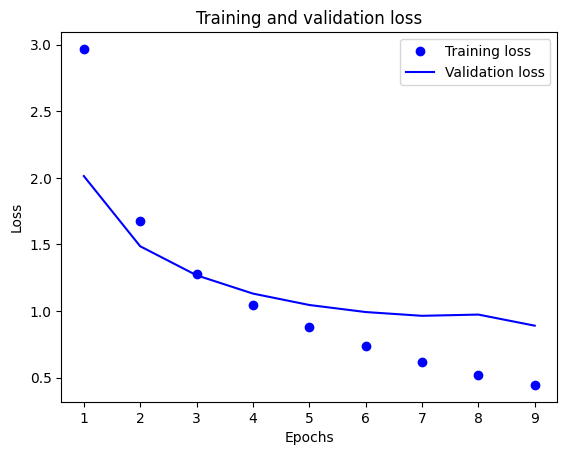

In [94]:
import matplotlib.pyplot as plt

loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()

plotando o training e validation accuracy

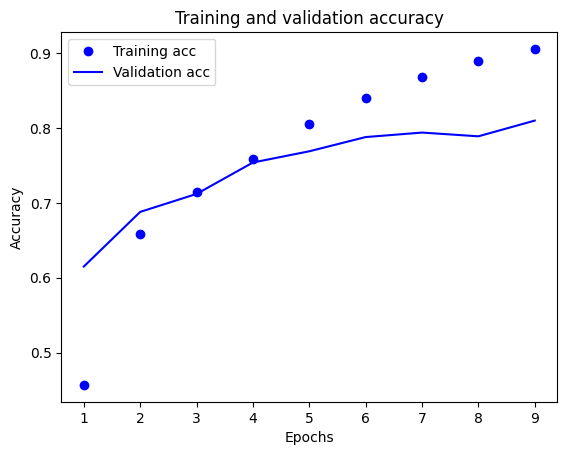

In [95]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.show()

o modelo apresenta um overfitting, pois o modelo apresenta um erro de validação maior que o erro de treinamento.

In [96]:
#Retreinando o modelo do 0
model = keras.Sequential([
	layers.Dense(64, activation="relu"),
	layers.Dense(64, activation="relu"),
	layers.Dense(46, activation="softmax")
])
model.compile(optimizer="rmsprop",
			loss="categorical_crossentropy",
			metrics=["accuracy"])
model.fit(x_train, y_train, epochs=9, batch_size=512)
results =model.evaluate(x_test, y_test)
results

Epoch 1/9
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5276 - loss: 2.6935
Epoch 2/9
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6755 - loss: 1.4953
Epoch 3/9
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7474 - loss: 1.1283
Epoch 4/9
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8072 - loss: 0.9013
Epoch 5/9
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8411 - loss: 0.7462
Epoch 6/9
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8720 - loss: 0.6142
Epoch 7/9
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8932 - loss: 0.5131
Epoch 8/9
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9116 - loss: 0.4280
Epoch 9/9
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9236 - loss: 0.3619
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7961 - loss: 0.9111


[0.9111121892929077, 0.7960819005966187]

This approach reaches an accuracy of ~80%. With a balanced binary classification problem, the accuracy reached by a purely random classifier would be 50%. But in this case, we have 46 classes, and they may not be equally represented. What would be the accuracy of a random baseline? We could try quickly implementing one to check this empirically:

In [97]:
import copy
test_labels_copy = copy.copy(test_labels)
np.random.shuffle(test_labels_copy)
hits_array = np.array(test_labels) == np.array(test_labels_copy)
hits_array.mean()

np.float64(0.17586821015138024)

As you can see, a random classifier would score around 19% classification accuracy, so the results of our model seem pretty good in that light.

### 4.2.5 Generating predictions on new data

Calling the model’s predict method on new samples returns a class probability distribution over all 46 topics for each sample. Let’s generate topic predictions for all of the test data:

In [98]:
predictions = model.predict(x_test)

71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


In [99]:
predictions[0].shape

(46,)

In [100]:
np.sum(predictions[0])

np.float32(0.9999999)

In [101]:
#The largest entry is the predicted class
np.argmax(predictions[0])

np.int64(3)

### A different way to handle the labels and the loss

In [102]:
#another way to encode the labels would be to cast them as an integer tensor
y_train = np.array(train_labels)
y_test = np.array(test_labels)

#the loss function for this case is sparse_categorical_crossentropy
model.compile(optimizer="rmsprop",
			loss="sparse_categorical_crossentropy",
			metrics=["accuracy"])
model.fit(x_train, y_train, epochs=9, batch_size=512)
results =model.evaluate(x_test, y_test)
results


Epoch 1/9
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9285 - loss: 0.3227
Epoch 2/9
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9394 - loss: 0.2628
Epoch 3/9
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9415 - loss: 0.2383
Epoch 4/9
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9483 - loss: 0.2082
Epoch 5/9
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9506 - loss: 0.1899
Epoch 6/9
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9499 - loss: 0.1753
Epoch 7/9
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9515 - loss: 0.1711
Epoch 8/9
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9544 - loss: 0.1529
Epoch 9/9
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9525 - loss: 0.1480
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7858 - loss: 1.0254


[1.0254056453704834, 0.7858415246009827]

### 4.2.8 Further experiments

Like in the previous example, I encourage you to try out the following experiments to train your intuition about the kind of configuration decisions you have to make with such models:  
- Try using larger or smaller layers: 32 units, 128 units, and so on. 
- You used two intermediate layers before the final softmax classification layer. Now try using a single intermediate layer, or three intermediate layers.

### Wrapping up

Here’s what you should take away from this example:
-  If you’re trying to classify data points among N classes, your model should end with a Dense layer of size N.
- In a single-label, multiclass classification problem, your model should end with a softmax activation so that it will output a probability distribution over the N output classes.
- Categorical crossentropy is almost always the loss function you should use for such problems. It minimizes the distance between the probability distributions output by the model and the true distribution of the targets.
- There are two ways to handle labels in multiclass classification:

 	– Encoding the labels via categorical encoding (also known as one-hot encoding) and using categorical_crossentropy as a loss function
  	
	– Encoding the labels as integers and using the sparse_categorical_crossentropy loss function

- If you need to classify data into a large number of categories, you should avoid creating information bottlenecks in your model due to intermediate layers that are too small.